In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import utils
from utils.get_nn_models import *
from utils.sbiutils import *
from utils.torchutils import *
from inference.base import *
import torch
import pickle
import seaborn as sns
import io
from utils.corruption import *
from simulators.oup import oup

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cpu


In [2]:
def load_models(root_name: str, device: torch.device):
    sum_net = torch.load("{root_name}/sum_net.pkl".format(root_name=root_name), map_location=device)

    density_estimator = torch.load("{root_name}/density_estimator.pkl".format(root_name=root_name), map_location=device)

    with open("{root_name}/posterior.pkl".format(root_name=root_name), "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
#     with open("{root_name}/inference.pkl".format(root_name=root_name), "rb") as handle:
#         inference = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, posterior

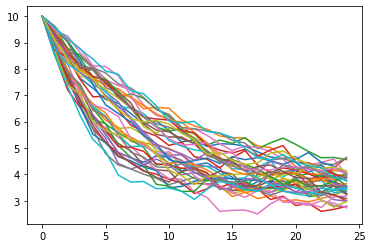

In [4]:
n = 25
theta = torch.tensor([1, 1.2])
simulator = oup(n=n, var=1)
Y = simulator(theta)
for i in range(20):
    plt.plot(range(n), Y[i])
n = 25
theta = torch.tensor([0.5, 1.2])
Y = simulator(theta)
for i in range(20):
    plt.plot(range(n), Y[i])

In [5]:
simulator = oup(var=1)
theta_gt = torch.tensor([0.5, 1])
theta_cont = torch.tensor([-0.5, 1])
obs = simulator(theta_gt).to(device)
obs_2 = simulator(theta_cont).to(device)
obs_cont = torch.cat([obs[:18], obs_2[:2]], dim=0).reshape(-1, 20, 25)

x = torch.tensor(np.load("data/oup_x_500.npy")).to(device)
theta = torch.tensor(np.load("data/oup_theta_500.npy")).to(device)
print("x shape", x.shape)
print("theta shape", theta.shape)

x shape torch.Size([500, 20, 25])
theta shape torch.Size([500, 2])


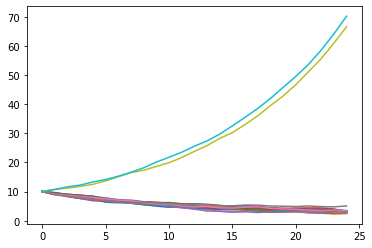

In [6]:
# theta_gt = torch.tensor([0.5, 1])
# obs = oup(theta_gt, var=1).to(device)
# obs_cont = copy.deepcopy(obs)

# obs_cont[:, 10:15] = 0
# print(obs_cont.shape)
for i in range(20):
    plt.plot(range(25), obs_cont[0][i])

In [496]:
root_name = "objects/oup/var=1_mmd_beta=2.0_theta=[0.5, 1.0]_num=1000/7"
# root_name = "objects/oup/var=1_mmd_beta=2.0_theta=[0.5, 1.0]_num=1000/2"
# root_name = "objects/oup/var=1_mmd_beta=2.0_theta=[0.5, 1.0]_num=500/2"
# root_name = "objects/oup/var=0.1_mmd_beta=2.0_theta=[0.5, 1.0]_num=500/8"
# root_name = "objects/oup/var=0.1_mmd_beta=3.0_theta=[0.5, 1.0]_num=500/4"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/oup/var=1_none_beta=2.0_theta=[0.5, 1.0]_num=1000/1"
# root_name = "objects/oup/var=1_none_beta=2.0_theta=[0.5, 1.0]_num=1000/9"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

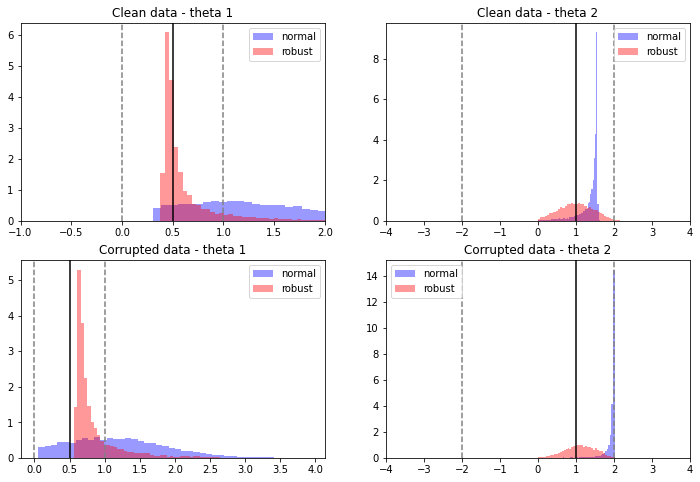

In [494]:
post_samples_normal_clean = posterior_normal.sample((10000,), x=obs.reshape(1, 1, 20, 25))
post_samples_robust_clean = posterior_robust.sample((10000,), x=obs.reshape(1, 1, 20, 25))
post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 20, 25))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 20, 25))

plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
plt.axvline(x=0,ls="--",c="grey")
plt.axvline(x=1,ls="--",c="grey")
sns.distplot(post_samples_normal_clean[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(-1, 2)
plt.title("Clean data - theta 1")

plt.subplot(2, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
plt.axvline(x=-2,ls="--",c="grey")
plt.axvline(x=2,ls="--",c="grey")
sns.distplot(post_samples_normal_clean[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(-4, 4)
plt.title("Clean data - theta 2")

plt.subplot(2, 2, 3)
plt.axvline(x=theta_gt[0],ls="-",c="black")
plt.axvline(x=0,ls="--",c="grey")
plt.axvline(x=1,ls="--",c="grey")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
# plt.xlim(-1, 2)
plt.title("Corrupted data - theta 1")

plt.subplot(2, 2, 4)
plt.axvline(x=theta_gt[1],ls="-",c="black")
plt.axvline(x=-2,ls="--",c="grey")
plt.axvline(x=2,ls="--",c="grey")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(-4, 4)
plt.title("Corrupted data - theta 2")
plt.show()


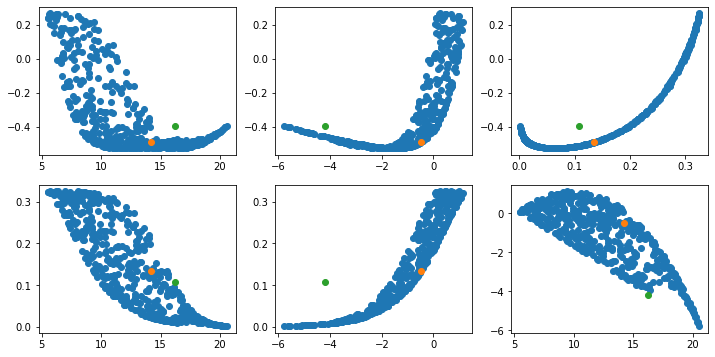

In [485]:
sum_net_normal_0 = copy.deepcopy(sum_net_normal)

obs_summary = sum_net_normal_0(obs.unsqueeze(0))[1].detach().numpy()
obs_cont_summary = sum_net_normal_0(obs_cont.unsqueeze(0))[1].detach().numpy()

x_summary = sum_net_normal_0(x[:500])[1].detach().numpy()

plt.figure(figsize=(12,6))
plt.subplot(2, 3, 1)
plt.scatter(x_summary[:, 0], x_summary[:, 3])
plt.scatter(obs_summary[0, 0], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 3])

plt.subplot(2, 3, 2)
plt.scatter(x_summary[:, 1], x_summary[:, 3])
plt.scatter(obs_summary[0, 1], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 3])

plt.subplot(2, 3, 3)
plt.scatter(x_summary[:, 2], x_summary[:, 3])
plt.scatter(obs_summary[0, 2], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 2], obs_cont_summary[0, 3])

plt.subplot(2, 3, 4)
plt.scatter(x_summary[:, 0], x_summary[:, 2])
plt.scatter(obs_summary[0, 0], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 2])

plt.subplot(2, 3, 5)
plt.scatter(x_summary[:, 1], x_summary[:, 2])
plt.scatter(obs_summary[0, 1], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 2])

plt.subplot(2, 3, 6)
plt.scatter(x_summary[:, 0], x_summary[:, 1])
plt.scatter(obs_summary[0, 0], obs_summary[0, 1])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 1])
plt.show()